Takes the whole relabeled fast dataset, combines all signals into one and then computes and plots the FFT and PSD.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from src.utils.path_utils import get_processed_fast_data_dir

In [2]:
label_names = {
    0: "Rest",
    1: "Grip",
    2: "Hold",
    3: "Release"
}

In [3]:
# ----------- Signal Aggregators ------------ #
label_voltages = {label: [] for label in range(4)}
fft_freqs = None
psd_freqs = None

In [4]:
# --- Load All Files ---
folder_path = str(get_processed_fast_data_dir())
csv_files = sorted(glob.glob(os.path.join(folder_path, "**/*.csv"), recursive=True))
if not csv_files:
    raise FileNotFoundError("No CSV files found in processed data directory.")

In [5]:
# ----------- Process Each File ------------ #
for file_path in csv_files:
    data = pd.read_csv(file_path, header=None, skiprows=1, names=['time', 'voltage', 'label'])

    time_diffs = np.diff(data['time'])
    sampling_rate = 1 / np.median(time_diffs)

    for label in sorted(data['label'].unique()):
        segment = data[data['label'] == label]
        voltage = segment['voltage'].values

        if len(voltage) < 512:
            continue

        label_voltages[label].append(voltage)

In [6]:
# ----------- Compute Combined FFT & PSD ------------ #
fft_results = {}
psd_results = {}

for label in range(4):
    if not label_voltages[label]:
        continue

    # Concatenate all voltage segments for this label
    combined_voltage = np.concatenate(label_voltages[label])

    # FFT
    n = len(combined_voltage)
    fft_freqs = np.fft.rfftfreq(n, d=1 / sampling_rate)
    fft_vals = np.fft.rfft(combined_voltage)
    fft_magnitude = np.abs(fft_vals)
    fft_results[label] = fft_magnitude

    # PSD using Welch's method
    psd_freqs, psd = welch(combined_voltage, fs=sampling_rate, nperseg=1024)
    psd_results[label] = psd

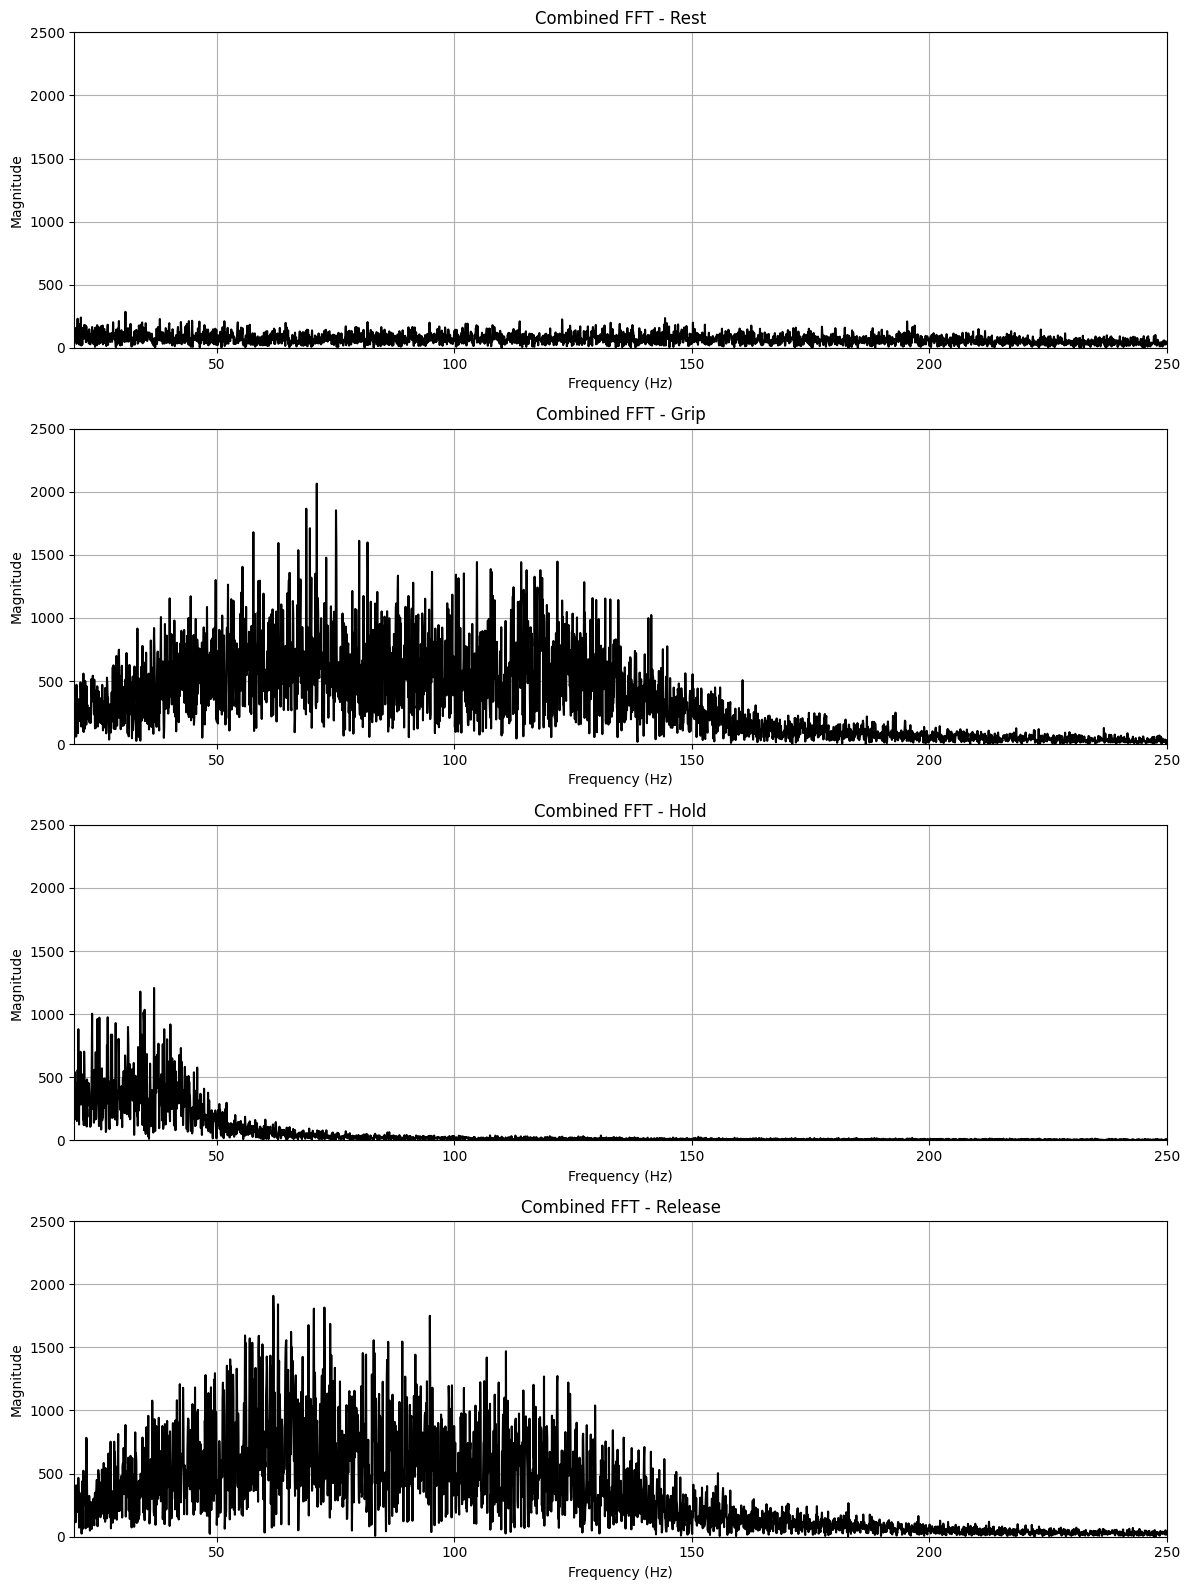

In [7]:
# Calculate the number of points for FFT (use power of 2 for efficiency)
n_points = 2**16  # or another appropriate power of 2

# Calculate FFT frequencies
sample_rate = 5000  # Replace with your actual sample rate
fft_freqs = np.fft.rfftfreq(n_points, d=1/sample_rate)

# Create subplots for FFT results
fig_fft, axs_fft = plt.subplots(len(fft_results), 1, figsize=(12, 4*len(fft_results)))
axs_fft = {label: axs_fft[i] for i, label in enumerate(fft_results.keys())}

for label in fft_results:
    # Find the minimum length between frequencies and FFT data
    min_length = min(len(fft_freqs), len(fft_results[label]))

    # Trim both arrays to the same length
    plot_freqs = fft_freqs[:min_length]
    plot_data = fft_results[label][:min_length]

    # Plot the data
    axs_fft[label].plot(plot_freqs, plot_data, color='black')
    axs_fft[label].set_title(f"Combined FFT - {label_names.get(label, f'Label {label}')}")
    axs_fft[label].set_xlim(20, 250)
    axs_fft[label].set_ylim(0, 2500)
    axs_fft[label].set_xlabel('Frequency (Hz)')
    axs_fft[label].set_ylabel('Magnitude')
    axs_fft[label].grid(True)

plt.tight_layout()
plt.show()

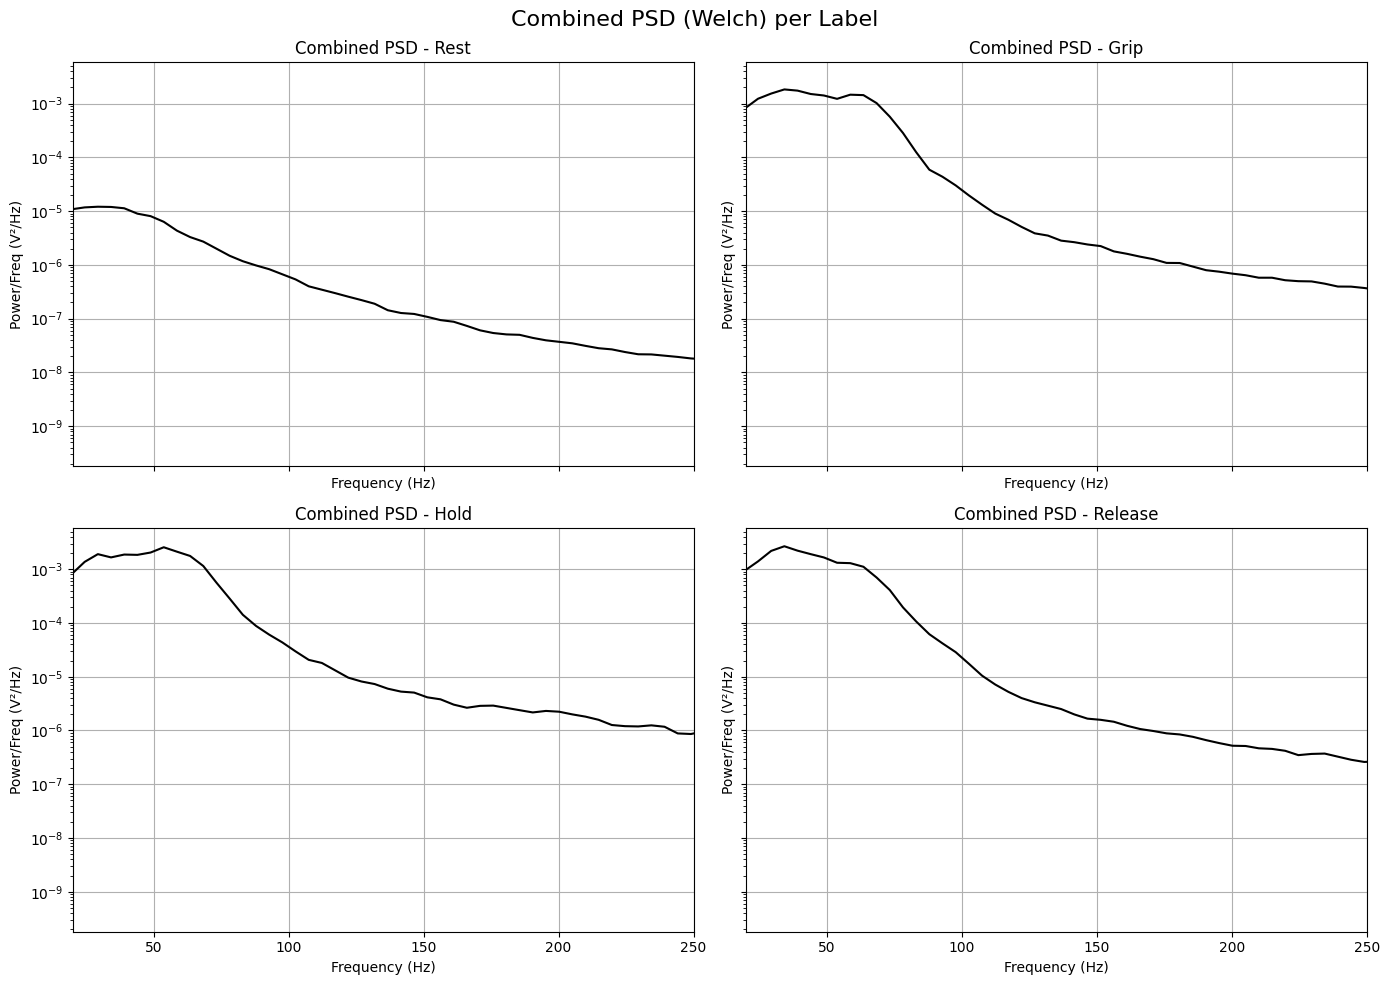

In [8]:
# ----------- Plot Combined PSD ------------ #
fig_psd, axs_psd = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axs_psd = axs_psd.flatten()

for label in range(4):
    if label in psd_results:
        axs_psd[label].semilogy(psd_freqs, psd_results[label], color='black')
        axs_psd[label].set_title(f"Combined PSD - {label_names.get(label, f'Label {label}')}")

        axs_psd[label].set_xlim(20, 250)
        axs_psd[label].set_ylabel("Power/Freq (V²/Hz)")
        axs_psd[label].grid(True)

for ax in axs_psd:
    ax.set_xlabel("Frequency (Hz)")

fig_psd.suptitle("Combined PSD (Welch) per Label", fontsize=16)
plt.tight_layout()
plt.show()